# Wczytanie Bibliotek

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import ColumnTransformer
import joblib
import matplotlib.pyplot as plt

# Wczytanie danych

Z początku odfiltrowujemy dane by ułatwić operowanie na danych. 
Przedziały wiekowe zostały ustalone żeby ułatwić predykcje i zebrać poszczególne grupy w stosunkowo podobnych wartościach.

By nie staracic wartościowych informacji z braków danych zostały one zmapowane jako 0 dla `Weapon Used Code` oraz pustego stringa dla `MO Codes`.

In [2]:
data = pd.read_csv('Crime_Data_2010_2017.csv')

data = data[~data['Victim Sex'].isin(['H', 'X', '-'])]
data = data[~data['Victim Descent'].isin(['-'])]

data['Weapon Used Code'] = data['Weapon Used Code'].fillna(0)
data['MO Codes'] = data['MO Codes'].fillna('')

bins = [0, 21, 29, 39, 51, 100]
labels = ['10-21', '22-29','30-39', '40-51', '52-100']
data['Victim Age'] = pd.cut(data['Victim Age'], bins=bins, labels=labels, right=False)

data = data[['Victim Age', 'Victim Sex', 'Victim Descent', 'Premise Code', 'Area ID', 'Crime Code', 'Weapon Used Code', 'Time Occurred', 'MO Codes', 'Status Code']]

# Próbkowanie danych

Będziemy przewidywać typy przestęptw, które na przestrzeni tworzenia zbioru przekroczyły wartość 10tys. wystąpień. Decyzja ta spowodowana jest tym, że klasy byłyby bardzo nieproporcjonalne co prowadziłoby do pogorszenia wyników. Proces uczenia modelu na tak dużej liczbie danych jest bardzo pamięciochłonny a ograniczenie ilości zmiennych objaśnianych pozwoli nam temu zapobiec. Dodatkowo dane są próbkowane czyli cały zbiór nie bierze udziału w uczeniu a raptem jego losowe 20% (`frac=0.2`). Są przestępstwa, które wystąpiły tylko raz więc ich przewidywanie nie miałoby żadnej wartości.

In [3]:
crime_code_counts = data['Crime Code'].value_counts()
frequent_crime_codes = crime_code_counts[crime_code_counts > 10000].index
data = data[data['Crime Code'].isin(frequent_crime_codes)]
data_sampled = data.sample(frac=0.2, random_state=42)

X = data_sampled[['Victim Age', 'Victim Sex', 'Victim Descent', 'Premise Code', 'Area ID', 'Weapon Used Code', 'Time Occurred', 'MO Codes', 'Status Code']]
y = data_sampled['Crime Code']

# Preprocesing

Dokonywana w tym kroku jest transformacja danych z kolumn tekstowych i kategorycznych. 

Przetwarzanie `MO_Codes` polega na konwersji tekstu na wektory częstotliwości słów czyli przekształca tekst na macierz z tokenami gdzie `max_features = 500` oznacza, że pod uwagę weźmie tylko 500 najczęściej występujących słów (tokenów), a `MO_Codes` jest kolumną z danymi.

Przetwarzanie pozostałych kolumn wykorzystuje OneHotEncoder czyli narzędzie do kodowania kategorycznych zmiennych jako macierz binarna. 

Zestawy treningowy i testowy są do siebie w stosunku odpowiednio 8:2.

In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        ('mo_codes', CountVectorizer(max_features=500), 'MO Codes'),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Victim Age', 'Victim Sex', 'Victim Descent', 'Premise Code', 'Area ID', 'Weapon Used Code', 'Time Occurred', 'Status Code'])
    ]
)

X_processed = preprocessor.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42, stratify = y)


print("Liczba danych w zbiorze treningowym przed SMOTE:", X_train.shape[0])
print("Liczba danych w zbiorze testowym:", X_test.shape[0])

Liczba danych w zbiorze treningowym przed SMOTE: 222877
Liczba danych w zbiorze testowym: 55720


# Użycie metody SMOTE

Metoda `SMOTE - Synthetic Minority Over-sampling Technique` polega na zbalansowaniu danych treningowych poprzez oversampling czyli sztuczne wytworzenie dodatkowych rekordów klas mniej licznych. 

Jej działanie można opisać jako:
- wybranie próbki z klasy mniejszościowej,
- znalezienie k najbliższych sąsiadów (`k_neighbors=5`),
- wylosowanie jednego z tych sąsiadów,
- wygenerowanie nowej próbki na linii łączącej wybraną próbkę i sąsiada.

Nowa macierz cech po zbalansowaniu, zawiera zarówno oryginalne, jak i sztuczne próbki.

In [7]:
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Liczba danych w zbiorze treningowym po SMOTE:", X_train_resampled.shape[0])

Liczba danych w zbiorze treningowym po SMOTE: 538384


# Uczenie modelu Random_Forest

W tym zadanu użyto modelu lasu losowego dzięki jego zdolnościom radzenia sobię z brakującymi danymi. Tworzenie lasu losowego polega na utworzeniu wielu drzew decyzyjnych. 

W tym lesie używamy 500 drzew decyzyjnych `n_estimators=500`, a maksymalną głebokość drzewa ustawiamy jako 50 `max_depth=50`.

In [8]:
model = RandomForestClassifier(n_estimators=500, max_depth=30, random_state=42)
model.fit(X_train_resampled, y_train_resampled)


y_pred = model.predict(X_test)

# Miary dopasowania

Miary użyte w celu weryfikacji zdolności generalizacyjnych modelu to: `Accuracy`, `Precision`, `Recall`, `F1`, `Confusion Matrix`.

Pierwsze cztery są to liczbowe miary dopasowania.

Miara `Accuracy` wskazuje wartość dokładności przewidywania na 71%. 

Pozostałe 3 `Precision`, `Recall`, `F1` odpowiednio dla wartości średnich wagowych: 73%, 71%, 70%, a dla średnich macro 62%, 64%, 61%.

`Confusion Matrix` czyli macierz pomyłek jest miarą graficzną, która ukazuje macierz poprawnie i niepoprawnie sklasyfikowanych próbek dla każdej klasy. Na głównej przekątnej znajdują się próbki prawidłowo sklasyfikowane, a poza nią próbki nieprawidłowo sklasyfikowane.


Model wykazuje stosunkowo dobrą wydajność klasyfikacji jak na złożoność problemu jakim jest przewidywanie typu popełnionego przestępstwa, jednakże pozostawia jeszcze przestrzeń do dalszych ulepszeń i modyfikacji modelu. 

Accuracy: 0.7054199569274946
Precision: 0.7270589644340288
Recall: 0.7054199569274946
F1-score: 0.6978149462486647
Classification Report:
               precision    recall  f1-score   support

         210       0.88      0.85      0.87      2450
         230       0.80      0.80      0.80      2714
         310       0.82      0.79      0.80      4462
         330       0.87      0.70      0.78      4836
         331       0.20      0.74      0.32       878
         341       0.33      0.44      0.38      2189
         350       0.37      0.55      0.44       421
         354       0.91      0.91      0.91      4051
         420       0.57      0.06      0.12      2546
         440       0.62      0.37      0.46      4422
         442       0.64      0.92      0.76      1288
         510       0.84      1.00      0.91      4886
         624       0.86      0.81      0.84      5852
         626       0.77      0.95      0.85      3400
         649       0.64      0.65      0.65       

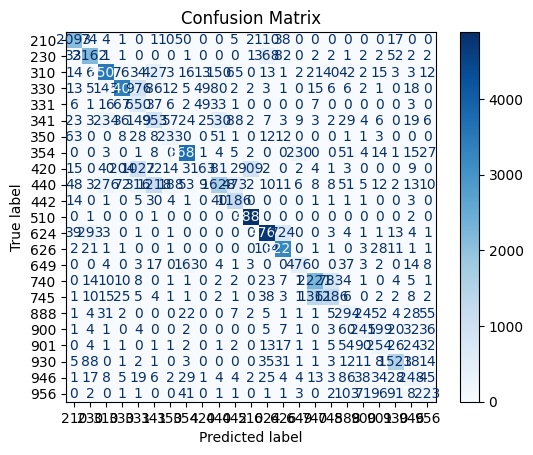

In [9]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Classification Report:\n", report)


disp = ConfusionMatrixDisplay(conf_matrix, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

# Zapisanie modelu

Cały proces uczenia zapisujemy do plików z rozszerzeniem `.pkl` aby móc użyć modelu w dedykowanej aplikacji z chatbotem.

In [10]:
joblib.dump(model, 'random_forest_model_crimes_10k_2.pkl')
joblib.dump(preprocessor, 'preprocessor_crimes_10k_2.pkl')

['preprocessor_crimes_10k_2.pkl']